# Brain Tumor Classification + TensorFlow + Data Augmentation 🩺
<div style="color:black;
           display:fill;
           border-radius:1px;
           background-color:#B2F6F5;
           font-size:100%;
           text-align: center;
           font-family:Verdana;
           letter-spacing:0.5px">
    
<p style="padding: 10px;
          color:black;
          text-align: justified;
          font-size:100%">
This notebook uses `TensorFlow v2` to build a brain tumor classification model from scratch.
Applied data augmenation using `tensorflow keras layers` to improve quality and quantity of data.
    <br><br>You can fork this notebook and make changes to the model. You can also do some preprocessing and make things even better, but if you do please leave an upvote. 😁 
</p>
</div>

<center>    
    <img src="https://img.shields.io/badge/Kaggle-Upvote%20If%20you%20like%20my%20work-blue?style=for-the-badge&logo=kaggle">
<center>

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Color palette
cmap = sns.color_palette("Blues")
# Properties
batch_size = 32
img_height = 180
img_width = 180

In [3]:
print("Color scheme:")
cmap

Color scheme:


[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

In [4]:
# Set path of the train directory
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

In [5]:
# Create a function to customize autopct parameter of plt.pie()
def make_autopct(values):
    def my_autopct(pct):
        # The pct is percentage value that matplotlib supplies for every wedge
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.2f}%  ({val})'
    return my_autopct

# Data Processing

### Read Training Data

In [6]:
# Create Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [7]:
# Create Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [8]:
# Get labels inferred by the method itself
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


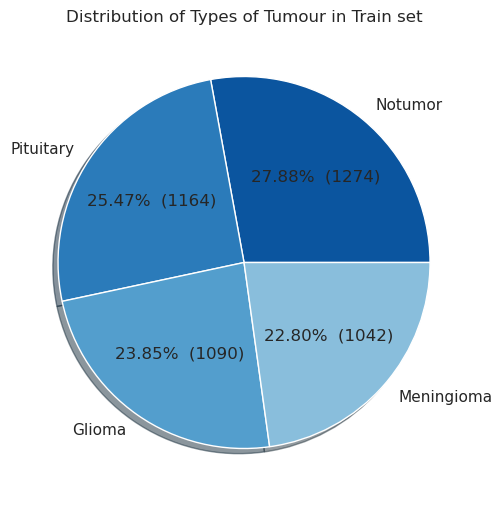

In [9]:
# Visualize Train Dataset
# Count instances in each class of train dataset
train_ds_labels = []

for _, labels in train_ds:
    for i in range(len(labels)):
        train_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': train_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our training data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Train set")
plt.show()

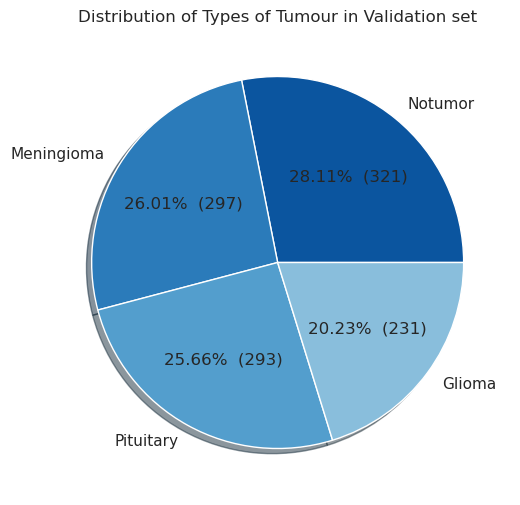

In [10]:
# Visualize Validation Dataset
# Count instances in each class of validation set
val_ds_labels = []

for _, labels in val_ds:
    for i in range(len(labels)):
        val_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': val_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our validation data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True, autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Validation set")
plt.show()

**Inference:** Both, the training set and the validation set have quite equal distribution of instances for each class. Thus, we dont't have to add any additional weigths to a particular class when we train our model.

In [11]:
def plot_images(n_rows, n_cols, data_set):
    """
    Plots a figure containing all images in paths_img
    along with paths_label
    
    Parameters:
    n_rows: number of rows to plot in figure
    n_cols: number of cols to plot in figure
    data_set: The dataset of images to plot
            data_set type: tf.data.Dataset
    """
    plt.figure(figsize=(n_cols*2.25, n_rows*2.25))
    for images, labels in train_ds.take(1):
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

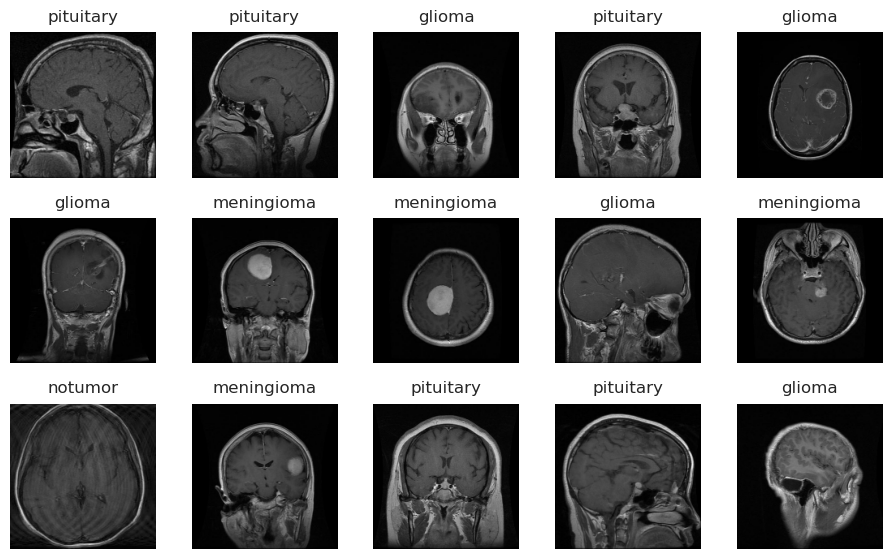

In [12]:
# View a few Images from Training dataset
plot_images(3, 5, train_ds)

### Autotune performance
Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

1. **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
2. **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize data and Data Augmentation

We will use the Keras preprocessing layers for data augmentation and apply those layers to our model.

The benefit of this approach is:
* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
* When we export our model using model.save, the preprocessing layers will be saved along with the rest of our model. If we later deploy this model, it will automatically standardize images (according to the configuration of our layers). This can save us from the effort of having to reimplement that logic server-side.

Also, data augmentation is inactive at test time so input images will only be augmented during calls to **Model.fit** (not **Model.evaluate** or **Model.predict**).

In [14]:
# Now we will scale pixels from range 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [15]:
# Apply some techniques like flip, rotate and zoom
# inorder to increase the quality and amount of data
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [16]:
def plot_images_augmented(dataset):
    """
    Parameters:
    : dataset - dataset of type `tf.data.Dataset` 
                with images to plot
    """
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

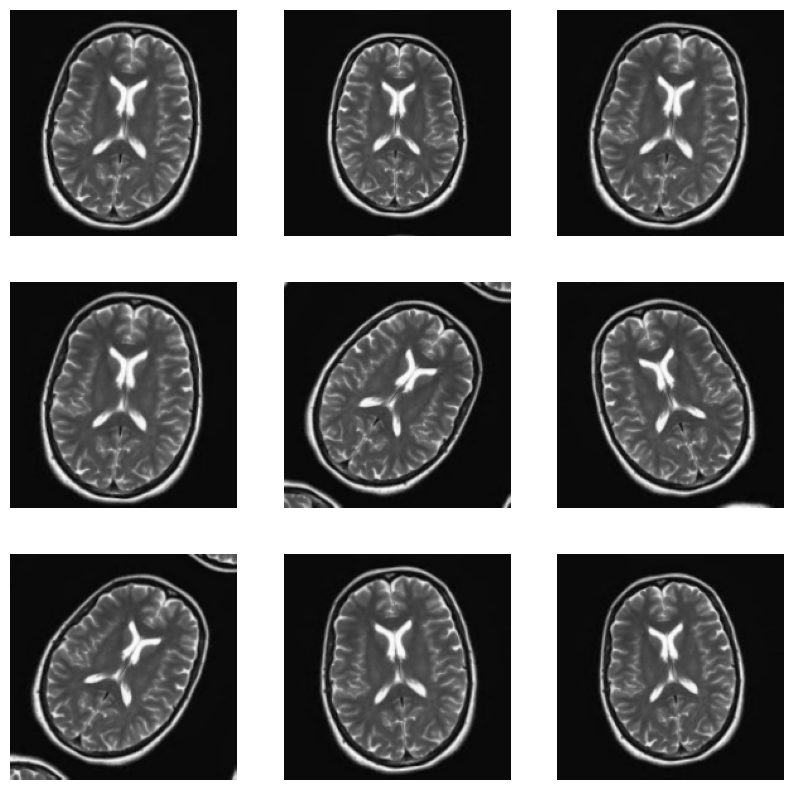

In [17]:
plot_images_augmented(train_ds)

# Train Model
Apply all data augmentation layers within model.

In [18]:
# Create model
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [19]:
# Compile the above model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# Look at the model's layers along with the number of parameters
# and shape of the input each layer accepts
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

**About Callbacks to be used:**
1. `ModelCheckpoint`: it will save checkpoints of our model at the end of each epoch and save model whose performance on validation set is best so far (if `save_best_model` parameter is set True)
2. `EarlyStopping`: interrupts training when no progress on validation set is made after several epochs (set by `patience` parameter) and loads back to best model (optionally)

In [21]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/kaggle/working/modelCheckpoint/brainT_detect.h5"
)
# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [22]:
# Fit model with our train data and cal-c validation 
# score at each epoch
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
# Model is saved again! (at different path)
model.save("brainT_detect.h5")

Epoch 1/100
143/143 [==============================] - 118s 792ms/step - loss: 0.8476 - accuracy: 0.6414 - val_loss: 0.8780 - val_accuracy: 0.6804
Epoch 2/100
143/143 [==============================] - 112s 786ms/step - loss: 0.5492 - accuracy: 0.7810 - val_loss: 0.7700 - val_accuracy: 0.7504
Epoch 3/100
143/143 [==============================] - 112s 782ms/step - loss: 0.4786 - accuracy: 0.8149 - val_loss: 0.9578 - val_accuracy: 0.6988
Epoch 4/100
143/143 [==============================] - 114s 794ms/step - loss: 0.4282 - accuracy: 0.8411 - val_loss: 0.5500 - val_accuracy: 0.8056
Epoch 5/100
143/143 [==============================] - 115s 804ms/step - loss: 0.3800 - accuracy: 0.8556 - val_loss: 0.5777 - val_accuracy: 0.7951
Epoch 6/100
143/143 [==============================] - 115s 804ms/step - loss: 0.3476 - accuracy: 0.8672 - val_loss: 0.7349 - val_accuracy: 0.7434
Epoch 7/100
143/143 [==============================] - 115s 803ms/step - loss: 0.3050 - accuracy: 0.8856 - val_loss: 0

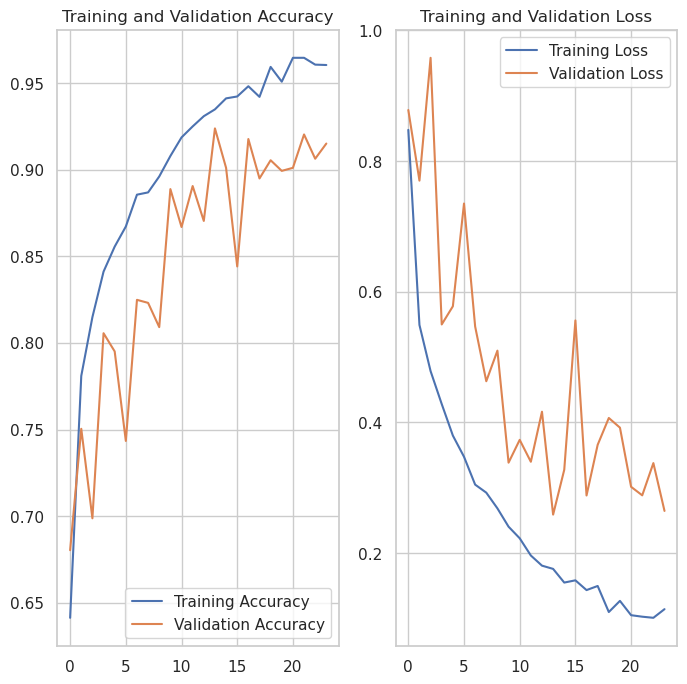

In [23]:
# Plot the training curves: train and validation accuracy & loss
epochs = len(history.epoch) # epochs completed by early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate Model

### Prepare test data

In [24]:
# Read test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1311 files belonging to 4 classes.


### Make Predictions

In [25]:
# Make predictions on test set
predictions = model.predict(test_ds)
# We use tf.nn.softmax as we applied padding in training & task is of multiclass 
# prediction. Threfore, we used `SparseCategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

41/41 [==============================] - 9s 194ms/step


In [26]:
for i in range(10):
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )

This image most likely belongs to meningioma with a 82.98 percent confidence.
This image most likely belongs to glioma with a 98.77 percent confidence.
This image most likely belongs to notumor with a 99.64 percent confidence.
This image most likely belongs to pituitary with a 99.84 percent confidence.
This image most likely belongs to meningioma with a 99.73 percent confidence.
This image most likely belongs to pituitary with a 99.56 percent confidence.
This image most likely belongs to notumor with a 99.51 percent confidence.
This image most likely belongs to pituitary with a 93.11 percent confidence.
This image most likely belongs to pituitary with a 99.82 percent confidence.
This image most likely belongs to meningioma with a 86.23 percent confidence.


## Confusion Matrix

In [27]:
# Create two numpy arrays to store labels of test data and prediction 
# of respective image
y_test_actual = np.array([])
y_pred_actual = np.array([])

# Iterate over every batch and enter data in created numpy arrays
for x, y in test_ds:
    # Convert label tensor to numpy and concatenate
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))
    # Process prediction score and concatenate result
    predictions = model.predict(x)
    scores = tf.nn.softmax(predictions[:])
    y_pred = np.argmax(scores, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

1/1 [==============================] - 0s 279ms/step


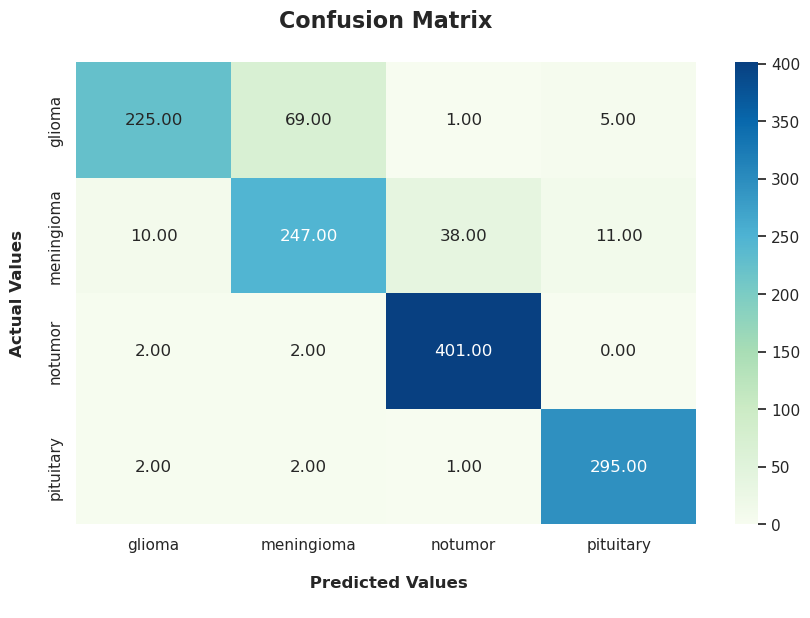

In [28]:
confusion = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(10,6))
fig = sns.heatmap(confusion, annot=True, fmt=".2f",cmap="GnBu")

fig.set_title('Confusion Matrix\n',
              fontdict={
                  "fontsize":16,
                  "fontweight": 'bold'
              })
fig.set_xlabel('\n Predicted Values\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.set_ylabel('Actual Values\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.xaxis.set_ticklabels(class_names)
fig.yaxis.set_ticklabels(class_names)
plt.show()

In [29]:
# Get classification report
print(classification_report(y_test_actual, y_pred_actual, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.94      0.75      0.83       300
  meningioma       0.77      0.81      0.79       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.89      1311
   macro avg       0.89      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311



**Accuracy will be improved in upcoming version.**

*Hope you liked the notebook! Feedback in comments section.*

<center>    
    <img src="https://img.shields.io/badge/Kaggle-Upvote%20If%20you%20like%20my%20work-blue?style=for-the-badge&logo=kaggle">
<center>